In [1]:
import importlib, os, gc, sys

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve, fmin
from scipy.signal import convolve as conv
import gsw
import cmocean.cm as cmo
from datetime import datetime as dt
import matplotlib.dates as mdates
import math

from matplotlib.gridspec import GridSpec

import glidertools as gt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.lines import Line2D

import matplotlib.colors as cl
from matplotlib.colors import ListedColormap

import matplotlib.ticker as mticker


import seaborn as sns
sns.set(
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'white',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=2.4) 

letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

import SXBQ as sx
import warnings
warnings.filterwarnings('ignore')

# Gridding functions

In [2]:
def interp(x,y,xi):
    _gg = np.isfinite(x+y)
    return interp1d(x[_gg], y[_gg], bounds_error=False, fill_value=np.NaN)(xi)

def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return grid,XI.T,YI.T

# grid in time and mask mld and wwl
def grid_t_mask(var):
    var_g, x, y=  grid2d(
        ds.time.values,
        ds.pressure.values, 
        ds[var]*ds['mld_mask']*ds['wwl_mask'].values, 
        xi=taxis, yi=yaxis, fn='mean')
    return var_g, x, y

# grid in time
def grid_t(var):
    var_g, x, y=  grid2d(
        ds.time.values,
        ds.pressure.values, 
        ds[var].values, 
        xi=taxis, yi=yaxis, fn='mean')
    return var_g, x, y

# grid in time adcp
def grid_t_adcp(var):
    var_g, x, y=  grid2d(
        dadcp.time.values,
        dadcp.pressure.values, 
        dadcp[var].values, 
        xi=taxis,  yi=yaxis, fn='mean')
    return var_g, x, y

## Load data 2021-22

## Grid data in timeseries format  - 2m bins, 4h 

In [3]:
ds= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/SEA057.nc')
dadcp= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/SEA057_adcp.nc')
ds_22= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_202122/final/gridded_SEA057.nc') ## gridded per section

In [4]:
yaxis=np.arange(0,1000,2)
taxis= np.arange(np.datetime64("2021-10-01"), np.datetime64("2022-10-31"), np.timedelta64(4, "h"))
taxis_trans_57=ds_22.time.values  ## average timestamp per transect

O22,XI, YI = grid_t('oxygen_concentration')
PGWfr, _,_ = grid_t_mask('pgw_frac')
TT, _,_ = grid_t('transect_num')
sigma,_,_=grid_t('potential_density')

dadcp.V_along_detided[dadcp.flag==True]=np.nan
V_refalong, _,_ = grid_t_adcp('V_along_detided')
V_refacross, _,_ = grid_t_adcp('V_across_detided')

dadcp.V_along_detided[dadcp.flag==True]=np.nan

dadcp.V_across_detided[dadcp.flag==True]=np.nan

V_refalong, _,_ = grid_t_adcp('V_along_detided')
V_refacross, _,_ = grid_t_adcp('V_across_detided')

## along shelf vel vs across -- 16 times larger along than across!!!
np.nanmean(np.abs(V_refalong[50:200])/np.abs(V_refacross[50:200]))

In [9]:
SAA, _,_ = grid_t('abs_salinity')
dis_, _,_ = grid_t('distance')
dis_=pd.DataFrame(dis_).bfill().interpolate(limit=10).interpolate(limit=5, axis=0).to_numpy()
msk_distanced= ((dis_>-3)& (dis_<47)).astype(float)
msk_distanced[msk_distanced==0]=np.nan

In [10]:
prof=XI.astype(int).copy()
prof[:]=np.arange(0,len(XI[0]))
mld=gt.physics.mixed_layer_depth(prof.flatten(), YI.flatten(), sigma.flatten(), thresh=0.125, ref_depth=2, return_as_mask=False).interpolate(limit=3).rolling(5, center=True).mean()

## Plotting functions

In [11]:
## plotting bathymetret in the timeseries in another color!
bat_arr=np.count_nonzero(~np.isnan(pd.DataFrame(O22).interpolate(limit=3, axis=1).to_numpy()), axis=0)
bat_arr[bat_arr>0]=1

bathim=YI*np.nan
bathim[:]=bat_arr

# Define the value ranges and corresponding colors
ranges = [0,1]
colors = ["w","gainsboro"] #
# Create a colormap based on the ranges and colors
cma2 = ListedColormap(colors)
norm2 = cl.BoundaryNorm(ranges, len(colors))

def axis_settings(ax, ax2, fnts):
    daily_=pd.date_range('2021-10-04 00:00:00', freq='14D', periods=25)
    for i in daily_:
        ax.axvline(i, linestyle='dotted', c='gray')
        
    daily_=pd.date_range('2022-07-04 00:00:00', freq='14D', periods=25)
    for i in daily_:
        ax2.axvline(i, linestyle='dotted', c='gray')
    ax.set_xlim(pd.to_datetime('10-04-2021'), pd.to_datetime('03-21-2022'))
    ax2.set_xlim(pd.to_datetime('07-01-2022'), pd.to_datetime('10-17-2022'))
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax2.yaxis.set_ticks([])

    d = .01/2 # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d), (-4*d,4*d), **kwargs)
    ax.plot((1-d,1+d),(1-4*d,1+4*d), **kwargs)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=2))
    ax.set_ylabel('Depth (m)', fontsize=fnts)
    d = .007 # how big to make the diagonal lines in axes coordinates
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d), (1-3*d,1+3*d), **kwargs)
    ax2.plot((-d,+d), (-3*d,+3*d), **kwargs)

    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=2))

    ax.set_ylim(500,0)
    ax2.set_ylim(500,0)
    
    
def axis_settings_transport(ax, ax2):

    daily_=pd.date_range('2021-10-11 00:00:00', freq='21D', periods=25)
    for i in daily_:
        ax.axvline(i, linestyle='dotted', c='silver', lw=3.5)
        
    daily_=pd.date_range('2022-07-11 00:00:00', freq='21D', periods=25)
    for i in daily_:
        ax2.axvline(i, linestyle='dotted', c='silver', lw=3.5)
    ax.set_xlim(pd.to_datetime('10-04-2021'), pd.to_datetime('03-21-2022'))
    ax2.set_xlim(pd.to_datetime('07-01-2022'), pd.to_datetime('10-17-2022'))
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax2.yaxis.set_ticks([])

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=3))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
    ax.tick_params(which='major', width=3,  length=10)
    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=3))
    ax2.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
    ax2.tick_params(which='major', width=3,  length=10)
    

def axis_settings_uv(ax, ax2, fnts):

    daily_=pd.date_range('2021-10-11 00:00:00', freq='21D', periods=25)
    for i in daily_:
        ax.axvline(i, linestyle='dotted', c='silver', lw=3.5)
        
    daily_=pd.date_range('2022-07-11 00:00:00', freq='21D', periods=25)
    for i in daily_:
        ax2.axvline(i, linestyle='dotted', c='silver', lw=3.5)
        
    ax.set_xlim(pd.to_datetime('10-04-2021'), pd.to_datetime('03-21-2022'))
    ax2.set_xlim(pd.to_datetime('07-01-2022'), pd.to_datetime('10-17-2022'))
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax2.yaxis.set_ticks([])
    
    d = .01/2 # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d,1+d), (-7*d,7*d), **kwargs)
    ax.plot((1-d,1+d),(1-7*d,1+7*d), **kwargs)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=3))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
    ax.tick_params(which='major', width=3,  length=10)
    
    ax.set_ylabel('Depth (m)', fontsize=fnts)
    d = .007 # how big to make the diagonal lines in axes coordinates
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d,+d), (1-5*d,1+5*d), **kwargs)
    ax2.plot((-d,+d), (-5*d,+5*d), **kwargs)


    
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=3))
    ax2.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY, interval=1))
    ax2.tick_params(which='major', width=3,  length=10)
    
## plotting sci formating ticks
class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

## Transport timeseries

In [13]:
## dist beteween prof
lat, XI_, YI_=sx.grid2d(ds.profile_num.values, ds.pressure.values, ds['latitude'].values, xi=1, yi=np.arange(0,1000,1), fn='mean')
lon, _, _=sx.grid2d(ds.profile_num.values, ds.pressure.values, ds['longitude'].values, xi=1, yi=np.arange(0,1000, 1), fn='mean')
lat_pp, lon_pp= pd.DataFrame(lat).mean(), pd.DataFrame(lon).mean()

missnum_=np.unique(ds.mission_num)[~np.isnan(np.unique(ds.mission_num))]
prof_first_miss=[np.nanmin(ds.profile_num[ds.mission_num==i]) for i in missnum_]

dist_betwen_prof=[np.nan]
for i in range(len(lon_pp)-1):
    dist_betwen_prof.append(gsw.distance([ lon_pp[i], lon_pp[i+1]], [lat_pp[i],lat_pp[i+1]])[0]/1000)

for i in (np.array(prof_first_miss)[1:]-1):  ## naning betweeen missions:)
    dist_betwen_prof[i]=np.nan
    
ds['delta_x']=(['profile_num'],np.array(dist_betwen_prof))
ds['cumsum_distance']=(['profile_num'],np.nancumsum(np.array(dist_betwen_prof)))

# spatial gridding for timeseries -- cumsumdstance and grid it in time. Get deltaX
cumsum_pptimesereis=interp(np.unique(ds.profile_num), ds.cumsum_distance.values ,ds.profile_num)
dis_, x_, y_=  grid2d(ds.time, ds.pressure.values,  cumsum_pptimesereis, xi=taxis, yi=yaxis, fn='mean')
DeltaX_timseries=np.concatenate([np.diff(np.nanmean(dis_, axis=0)), [np.nan]])

# plotting histogram of distances between profile
print('mean distance between profiles (km)    =  ' + str(np.nanmean(DeltaX_timseries)))
mkspg=(PGWfr>.25)

# " Transport: H = integral (P * v *dA) where P is propoerty advected (P=1 if volume transport), v is alogshelf velocities and dA is dlxdz= distance between profiles x vertical grid bin (2m)
# Volume transport along shelf: P=1
transp_all=np.nansum(V_refalong*msk_distanced*2*(DeltaX_timseries*1000)/1000000,axis=0)
transp_all[transp_all==0]=np.nan

# PGW volume transport along shelf:  P=PGWf
transp=np.nansum(V_refalong*PGWfr*msk_distanced*2*(DeltaX_timseries*1000)/1000000,axis=0) # UNITS: [m/s] * [] * [m] * [m] =[m3/s] and / 10**6 = [Sverdrups]
transp[transp==0]=np.nan

# PGW volume transport along shelf:  P=PGWf >0.25
transppf=np.nansum(V_refalong*mkspg*msk_distanced*2*(DeltaX_timseries*1000)/1000000,axis=0) # UNITS: [m/s] * [] * [m] * [m] =[m3/s] and / 10**6 = [Sverdrups]
transppf[transppf==0]=np.nan

## Transport per transect

In [17]:
def trans_per_transect(fr):
    lol=pd.DataFrame(fr).set_index(np.nanmax(TT, axis=0)).sort_index()
    lol=lol[lol.index.notnull()]
    lol=lol.to_xarray()
    return lol    ## to do: normalize by length tranect!

pgw_TT=trans_per_transect(transp)
all_TT=trans_per_transect(transp_all)

mean_transp=pgw_TT.groupby_bins(pgw_TT.index, bins=np.arange(0,71,1)).mean()[0] ## if sum, we get total transport per trasnect instead of a mean:)
mean_all_TT=all_TT.groupby_bins(all_TT.index, bins=np.arange(0,71,1)).mean()[0]

## mask length of transect longer than 10km and shorter than 50km
msk_transport=((pgw_TT.groupby_bins(pgw_TT.index, bins=np.arange(0,71,1)).count()[0]>10)& (pgw_TT.groupby_bins(pgw_TT.index, bins=np.arange(0,71,1)).count()[0]<50))

count_all_TT=all_TT.groupby_bins(all_TT.index, bins=np.arange(0,71,1)).count()[0]
count_pgw_TT=pgw_TT.groupby_bins(all_TT.index, bins=np.arange(0,71,1)).count()[0]

sum_transp=pgw_TT.groupby_bins(pgw_TT.index, bins=np.arange(0,71,1)).sum()[0] ## if sum, we get total transport per trasnect instead of a mean:)
sum_all_TT=all_TT.groupby_bins(all_TT.index, bins=np.arange(0,71,1)).sum()[0]

sum_transp= sum_transp[msk_transport]
sum_all_TT= sum_all_TT[msk_transport]

## Glider depth average velocity vs. gesotrophic velocities dervied from ssh (Copernicus - duacs)

In [20]:
UU_mn=pd.DataFrame(np.nanmean(V_refalong, axis=0)).rolling(6, center=True).mean()[0].to_numpy()
lat, _,_ = grid_t('latitude')
lon, _,_ = grid_t('longitude')

lat_mn=np.nanmean(lat, axis=0)
lon_mn=np.nanmean(lon, axis=0)

# Load ssh geostrophic velocities dataset:
df= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/dataset-duacs-nrt-global-merged-allsat-phy-l4_1690537288253.nc')

# colocate glider to ssh grid field lat - lon - time
v_gos, u_gos=[], []
for i in tqdm(range(len(taxis))):
    fr=df.sel(longitude=lon_mn[i], method="nearest").sel(latitude=lat_mn[i], method="nearest").sel(time=taxis[i], method="nearest")
    u_gos.append(fr.ugos.item())
    v_gos.append(fr.vgos.item())    
u_gos=np.array(u_gos)
v_gos=np.array(v_gos)

# Compute along shelf component to compare to glider V_along averaged
along_gos=u_gos*np.cos(np.deg2rad(25))-v_gos*np.sin(np.deg2rad(25))

  0%|          | 0/2370 [00:00<?, ?it/s]

## EKE

In [21]:
## satelite eke - mean is over 110 days to keep ineterseaon

df_14= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1693900584098.nc')
df_1= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/c3s_obs-sl_glo_phy-ssh_my_twosat-l4-duacs-0.25deg_P1D_1690546044610.nc')
df_2= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/dataset-duacs-nrt-global-merged-allsat-phy-l4_1690537288253.nc')
df_23= xr.open_dataset('/home/jupyter-estelfont/datasets/ssh/dataset-duacs-nrt-global-merged-allsat-phy-l4_1693900327657.nc')
df=xr.merge([df_14, df_1, df_2, df_23])

df['u_prime']=df.ugos-df.ugos.rolling(time=110,center=True).mean()
df['v_prime']=df.vgos-df.vgos.rolling(time=110,center=True).mean()
df['EKE']=0.5*(df['u_prime']**2+df['v_prime']**2)

## mean over only the year of glider instead of roll mean
df_subsel_2121=df.sel(time=slice('2021-10', '2022-10'))
df_subsel_2121['u_prime']=df_subsel_2121.ugos-df_subsel_2121.ugos.mean()
df_subsel_2121['v_prime']=df_subsel_2121.vgos-df_subsel_2121.vgos.mean()
df_subsel_2121['EKE']=0.5*(df_subsel_2121['u_prime']**2+df_subsel_2121['v_prime']**2)

## collocate sat on transect glider and time
lon_lat_transect=np.linspace(57.4931,57.9126, 90), np.linspace(24.0397,24.6507, 90)
def EKE_pertransect(Trans_Num):
    EKE_satel=[]
    tid=ds_22.isel(trans_num=Trans_Num).time.values
    for i in range(90):
        fr=df_subsel_2121.sel(longitude=lon_lat_transect[0][i], method="nearest").sel(latitude=lon_lat_transect[1][i], method="nearest").sel(time=tid, method="nearest")
        EKE_satel.append(fr.EKE.item())
    # v_gos.append(fr.vgos.item())    
    EKE_satel=np.array(EKE_satel)
    return EKE_satel

## collocate to glider timeseries per dive latlon and time.
EKE_glider_anualmean=[]
for i in tqdm(range(len(taxis))):
    fr=df_subsel_2121.sel(longitude=lon_mn[i], method="nearest").sel(latitude=lat_mn[i], method="nearest").sel(time=taxis[i], method="nearest")
    EKE_glider_anualmean.append(fr.EKE.item())
EKE_glider_anualmean=np.array(EKE_glider_anualmean)

  0%|          | 0/2370 [00:00<?, ?it/s]

In [24]:
## glider eke: gridded sections -- get eke (mean is over alll glider sections):
msk_numtrasn= (ds_22.V_across_detided.count(dim='trans_num')>50).values.astype(float)
msk_numtrasn[msk_numtrasn==0]=np.nan

ds_22['V_across_prime']=ds_22.V_across_detided.rolling(x=3, center=True).mean().rolling(y=1, center=True).mean()*msk_numtrasn-ds_22.V_across_detided.mean(dim='trans_num').rolling(x=5, center=True).mean().rolling(y=10, center=True).mean()*msk_numtrasn
ds_22['V_along_prime']=ds_22.V_along_detided.rolling(x=3, center=True).mean().rolling(y=1, center=True).mean()*msk_numtrasn-ds_22.V_along_detided.mean(dim='trans_num').rolling(x=5, center=True).mean().rolling(y=10, center=True).mean()*msk_numtrasn
ds_22['EKE_adcp']=0.5*(ds_22['V_along_prime']**2+ds_22['V_across_prime']**2)

### mask certain transects:
# average_EKE_transect= np.array([EKE_pertransect(i)[5:55] for i in range(70)]) ## from sat
try_msk=msk_transport.astype(float).values
try_msk[try_msk==0]=np.nan

average_EKE_transect= np.array([EKE_pertransect(i)[5:55] for i in range(70)]) ## from sat
norm_EKEintegrated=((ds_22.EKE_adcp.sum('y').values/np.count_nonzero(~np.isnan(ds_22.EKE_adcp), axis=1)).T*(try_msk)).T.flatten() ## from glider

mean_EKE_trans=np.nanmean(average_EKE_transect, axis=1)
for i in [17,18,25,26,33,34,35,36,42, 52,53,58,59,60,61]:
    mean_EKE_trans[i]=np.nan

mean_EKEADCP_trans=ds_22['EKE_adcp'].mean('y').mean('x').values.flatten()
for i in [17,18,25,26,33,34,35,36,42, 52,53,58,59,60,61]:
    mean_EKEADCP_trans[i]=np.nan
msk_vel=(UU_mn/UU_mn)

norm_EKEintegrated_organized=pd.DataFrame(norm_EKEintegrated).set_index(pd.to_datetime(ds_22.time_grid.mean('y').values.flatten())).sort_index()
vel_dif=(UU_mn- along_gos*msk_vel)

In [29]:
# PLOT

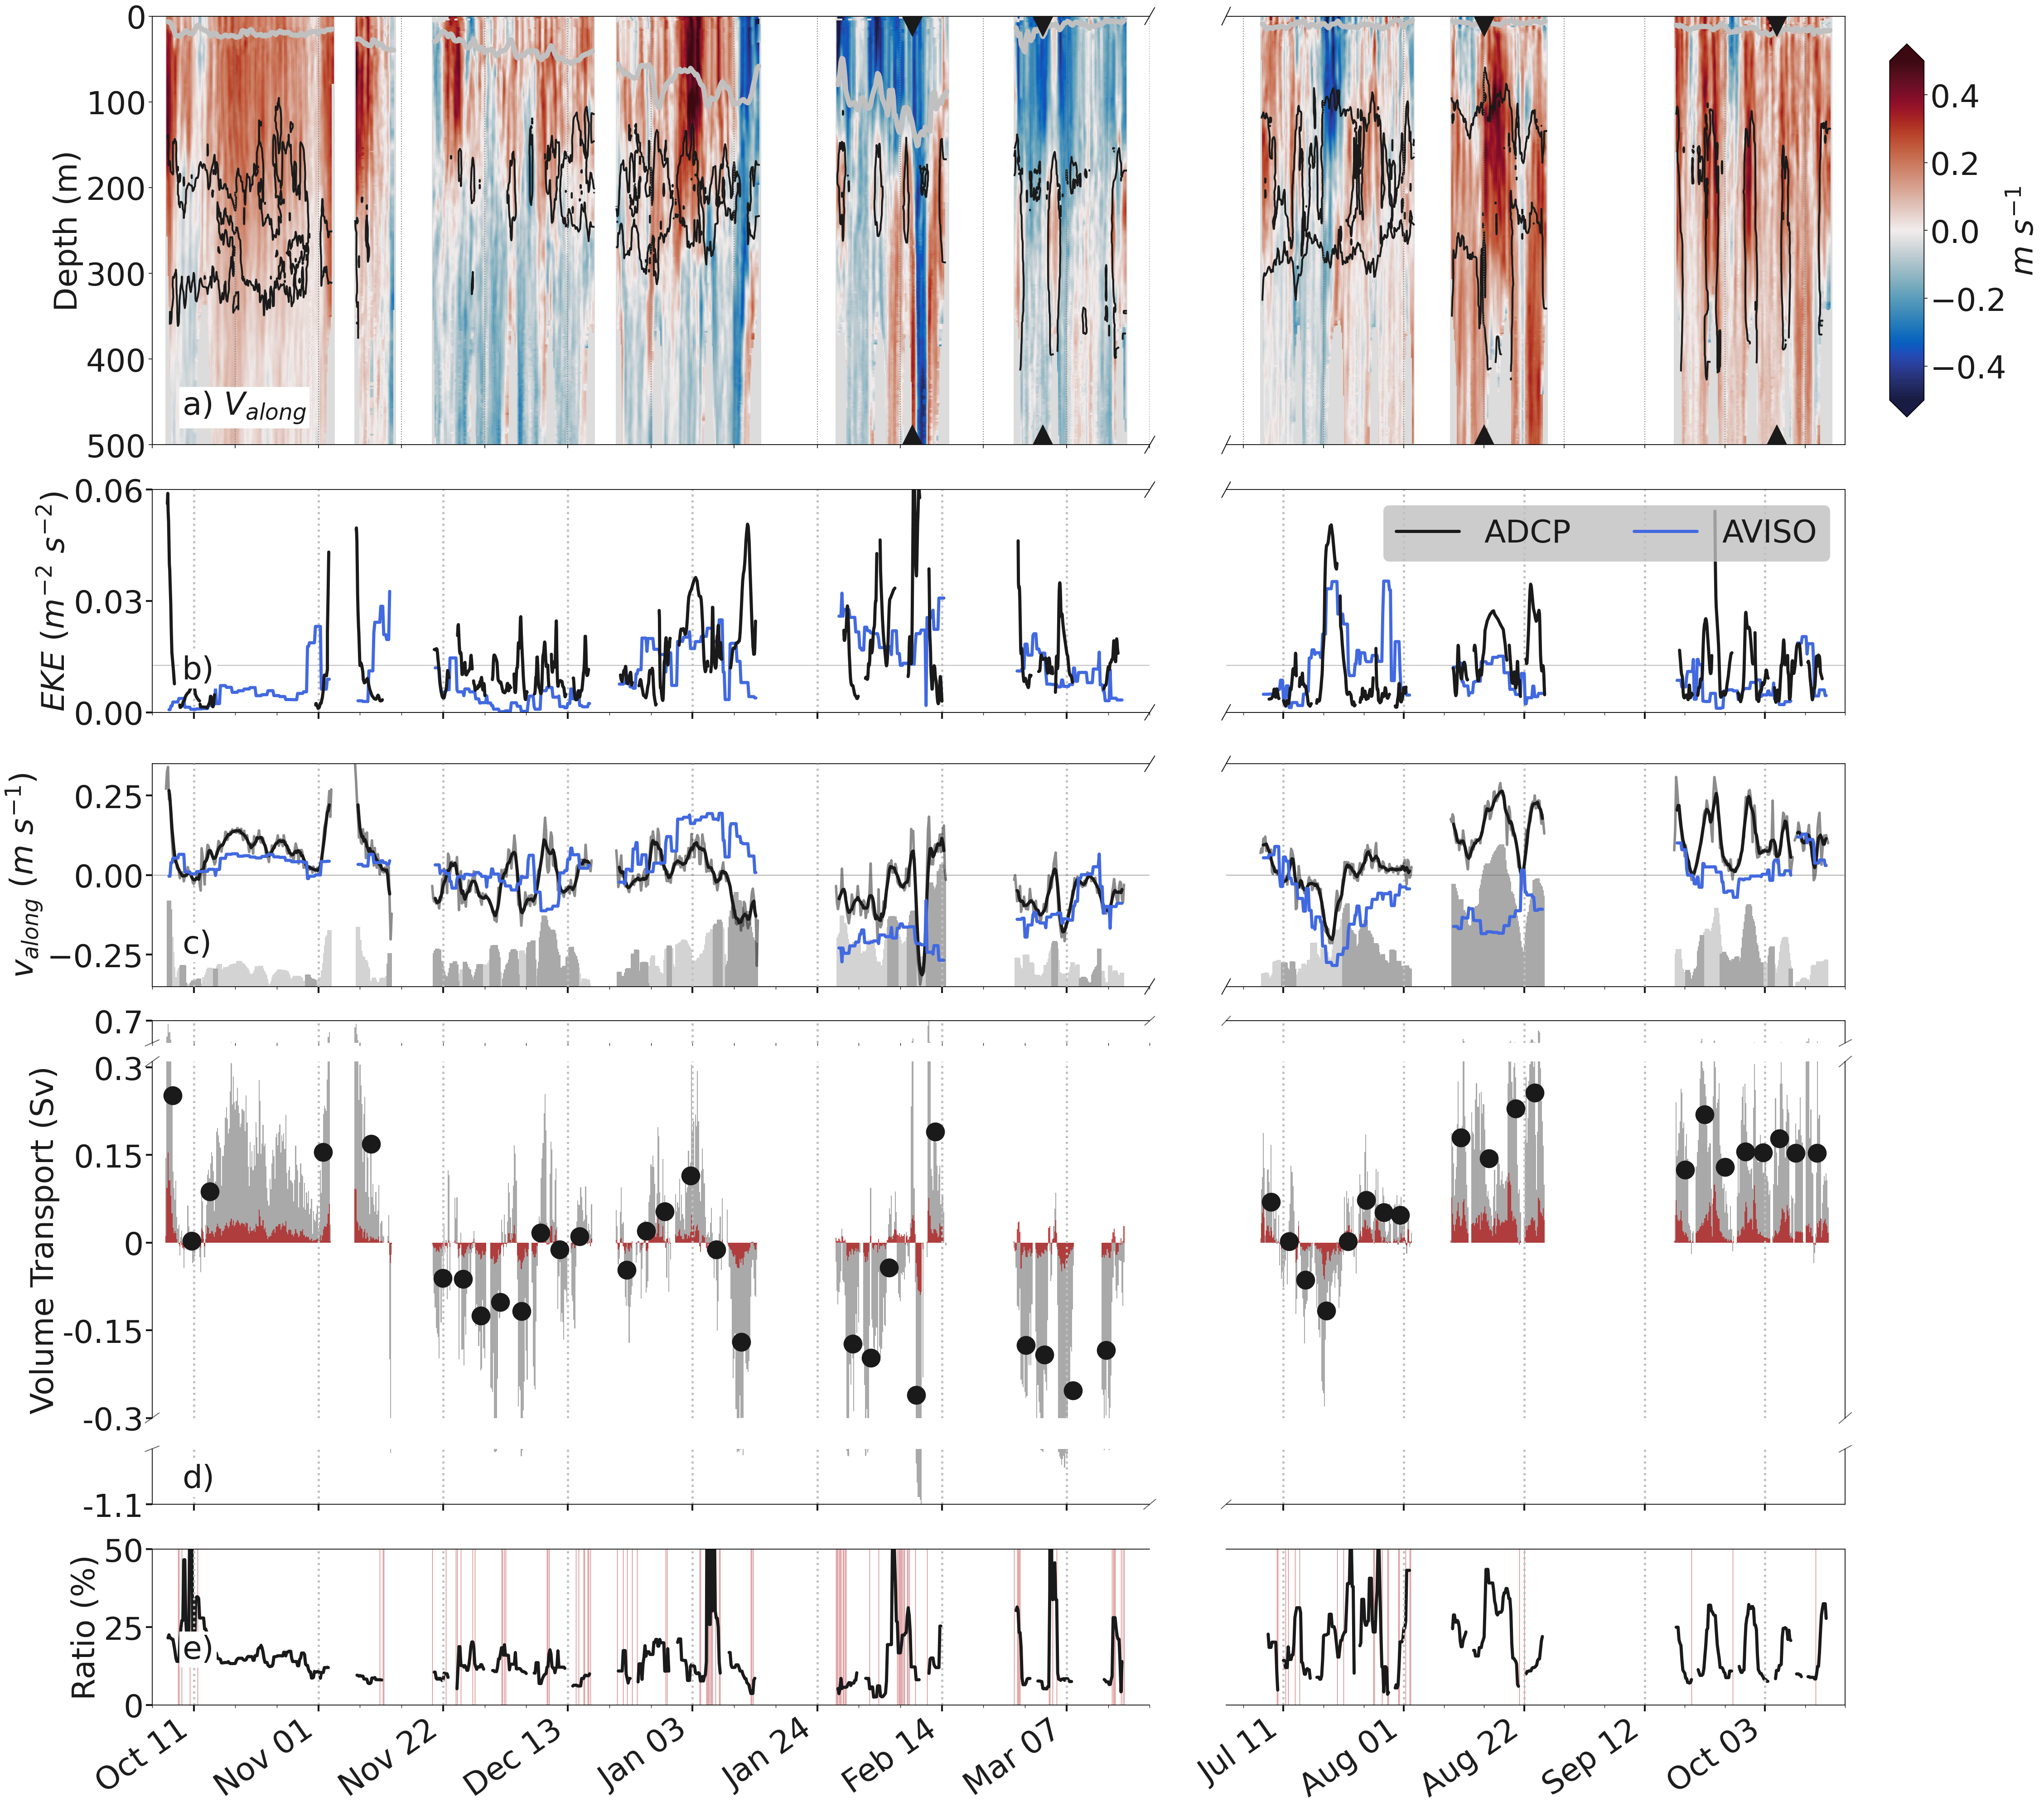

In [86]:
fnts=50
alp=1
minn=.03
linw=5
color_tri='k'
ff = plt.figure(constrained_layout=True, figsize=(45,40))

spec2 = GridSpec(ncols=50, nrows=72+34+12+18-29, figure=ff)
sixee=60
right, mid, left=0, 29, 48

'--------PGW frac sections-------------'

'----------Valong sections-----------'

frame, CMAP, VMIN, VMAX, LABEL=V_refalong, cmo.balance, -0.5, 0.5, r'$m$ $s^{-1}$'


ax = ff.add_subplot(spec2[29-29:56-29, right:mid])
ax2 = ff.add_subplot(spec2[29-29:56-29, mid+1:left])

t=ax.text(x=minn,y=.07,s=letters[0] + ') $V_{along}$',size=fnts,transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

ax.pcolormesh(XI, YI, bathim, cmap=cma2, norm=norm2)
ax2.pcolormesh(XI, YI, bathim, cmap=cma2, norm=norm2)

ax.pcolormesh(XI, YI, pd.DataFrame(frame).interpolate(limit=3, axis=1).rolling(3, axis=1, center=True).mean().to_numpy(),cmap=CMAP,vmin=VMIN, vmax=VMAX, shading="auto")
cb=ax2.pcolormesh(XI, YI, pd.DataFrame(frame).interpolate(limit=3, axis=1).rolling(3, axis=1, center=True).mean().to_numpy(),cmap=CMAP, vmin=VMIN, vmax=VMAX, shading="auto")
ax.set_ylim(500,0)

'-------'

cbaxes = ff.add_subplot(spec2[31-29:54-29, left+1])
cbb=plt.colorbar(cb, cax=cbaxes, extend= 'both')
cbb.set_label(LABEL, fontsize=fnts)
cbb.ax.tick_params(labelsize=fnts)

cs=ax.contour(XI, YI, pd.DataFrame(PGWfr).interpolate(limit=3, axis=1).to_numpy(), levels= [0.25],colors=["k", "w"], linewidths=[3,linw])
cs=ax2.contour(XI, YI, pd.DataFrame(PGWfr).interpolate(limit=3, axis=1).to_numpy(), levels= [0.25],colors=["k", "w"], linewidths=[3,linw])
ax2.set_ylim(500,0)

ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)
axis_settings(ax,ax2, fnts)
ax2.xaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])

ax.plot(taxis, mld, c='silver', lw=8)
ax2.plot(taxis, mld, c='silver', lw=8)

ax.scatter(pd.to_datetime('2022-03-03'), 500, s=4000, marker='^', c=color_tri, zorder=100)
ax.scatter(pd.to_datetime('2022-03-03'), 0, s=4000, marker='v', c=color_tri, zorder=100)

ax.scatter(pd.to_datetime('2022-02-09'), 500, s=4000, marker='^', c=color_tri, zorder=100)
ax.scatter(pd.to_datetime('2022-02-09'), 0, s=4000, marker='v', c=color_tri, zorder=100)

ax2.scatter(pd.to_datetime('2022-08-15'), 500, s=4000, marker='^', c=color_tri, zorder=100)
ax2.scatter(pd.to_datetime('2022-08-15'), 0, s=4000, marker='v', c=color_tri, zorder=100)

ax2.scatter(pd.to_datetime('2022-10-05'), 500, s=4000, marker='^', c=color_tri, zorder=100)
ax2.scatter(pd.to_datetime('2022-10-05'), 0, s=4000, marker='v', c=color_tri, zorder=100)



'---------EKE------------'

ax = ff.add_subplot(spec2[58-29:72-29, right:mid])
t=ax.text(x=minn,y=.15,s=letters[1] + ')',size=fnts,transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

ax2 = ff.add_subplot(spec2[58-29:72-29, mid+1:left])
axis_settings_uv(ax,ax2, fnts)
ax.set_ylim(0,0.06)
ax.set_yticks([0,0.03,0.06])

ax2.set_ylim(0,0.06)

ax.set_xticklabels([])
ax2.set_xticklabels([])
ax.axhline(0, c='dimgrey', alpha=0.5)
ax2.axhline(0, c='dimgrey', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)


ax.axhline(np.nanmean(norm_EKEintegrated), c='silver')#+np.nanstd(norm_EKEintegrated)    )
ax.plot(taxis, EKE_glider_anualmean*msk_vel, c='royalblue', lw=linw)
mks_eke_glider=norm_EKEintegrated_organized/norm_EKEintegrated_organized
ax.plot(norm_EKEintegrated_organized.interpolate(limit=2, method='linear',axis=0).rolling(3, center=True).mean()*mks_eke_glider, lw=linw,c='k')

ax2.axhline(np.nanmean(norm_EKEintegrated), c='silver')#+np.nanstd(norm_EKEintegrated)    )
ax2.plot(taxis, EKE_glider_anualmean*msk_vel, c='royalblue',lw=linw)
mks_eke_glider=norm_EKEintegrated_organized/norm_EKEintegrated_organized
ax2.plot(norm_EKEintegrated_organized.interpolate(limit=2, method='linear',axis=0).rolling(3, center=True).mean()*mks_eke_glider, lw=linw,c='k')

ax.set_ylabel('$EKE$ ($m^{-2}$ $s^{-2}$)', fontsize=fnts)

line = Line2D([0], [0], label='ADCP', color='k', lw=linw)
line2 = Line2D([0], [0], label='AVISO', color='royalblue', lw=linw)
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([line,line2])
plt.legend(handles=handles, loc=1, ncol=2, fontsize=fnts, fancybox=True, facecolor='silver')

'----------V_along-----------------'

ax = ff.add_subplot(spec2[76-29:90-29, right:mid])
t=ax.text(x=minn,y=.15,s=letters[2] + ')',size=fnts,transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

'-----------'

ax2 = ff.add_subplot(spec2[76-29:90-29, mid+1:left])
axis_settings_uv(ax,ax2, fnts)
ax.set_ylim(-0.35,0.35)
ax2.set_ylim(-0.35,0.35)
ax.set_xticklabels([])
ax2.set_xticklabels([])
ax.axhline(0, c='dimgrey', alpha=0.5)
ax2.axhline(0, c='dimgrey', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)


ax3=ax.twinx()
ax3.bar(taxis, np.abs(vel_dif)*((UU_mn*along_gos*msk_vel)>0), color='lightgray', edgecolor=None, linewidth=0, zorder=-3000)
ax3.bar(taxis, np.abs(vel_dif)*((UU_mn*along_gos*msk_vel)<0), color='darkgrey', edgecolor=None, linewidth=0, zorder=-3000)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.spines['right'].set_visible(False)

ax3.set_ylim(0,0.7)

ax3=ax2.twinx()
ax3.bar(taxis, np.abs(vel_dif)*((UU_mn*along_gos*msk_vel)>0), color='lightgray', edgecolor=None, linewidth=0)
ax3.bar(taxis, np.abs(vel_dif)*((UU_mn*along_gos*msk_vel)<0), color='darkgrey', edgecolor=None, linewidth=0)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.spines['left'].set_visible(False)

ax3.set_ylim(0,0.7)

ax.set_zorder(1) 
ax.set_frame_on(False)
ax.plot(taxis, np.nanmean(V_refalong, axis=0), lw=linw-1,c='k', alpha=0.5, zorder=3000)
ax.plot(taxis,UU_mn, c='k', lw=linw,label='ADCP', zorder=3000)
ax.plot(taxis, along_gos*msk_vel, c='royalblue',  lw=linw, label='AVISO', zorder=3000)

ax2.set_zorder(1) 
ax2.set_frame_on(False)
ax2.plot(taxis, np.nanmean(V_refalong, axis=0), lw=linw-1, c='k', alpha=0.5, zorder=3000)
ax2.plot(taxis,UU_mn, lw=linw,c='k', zorder=3000)
ax2.plot(taxis, along_gos*msk_vel, c='royalblue', lw=linw, zorder=3000)


ax.set_ylabel('$v_{along}$ ($m$ $s^{-1}$)', fontsize=fnts)

ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)

'--------Transport-------------'

NN=90-29
ax = ff.add_subplot(spec2[NN+2:NN+4, right:mid])

ax.bar(taxis, transp_all , linewidth=0, width=np.diff(taxis)[0], align='center', edgecolor='darkgrey', color='darkgrey')
ax.set_ylim(0.3,0.7)
ax.set_yticks([0.7])

'----------'

ax2 = ff.add_subplot(spec2[NN+2:NN+4, mid+1:left])
ax2.bar(taxis, transp_all , linewidth=0, width=np.diff(taxis)[0], align='center', edgecolor='darkgrey', color='darkgrey')
ax2.set_ylim(0.3,0.7)

axis_settings_transport(ax,ax2)
ax2.xaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
ax.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)

d = .005 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='dimgray', clip_on=False)
ax.plot((1-d,1+d), (1-40*d,1+40*d), **kwargs)
d = .007 # how big to make the diagonal lines in axes coordinates
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-30*d,1+30*d), **kwargs)

ax2.xaxis.set_ticks([])
ax.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])

d = .007  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='dimgrey', clip_on=False)
ax.plot((-d, +d), (-20*d, +20*d), **kwargs)        # top-left diagonal

d = .01  # how big to make the diagonal lines in axes coordinates
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((1 - d, 1 + d), (-15*d, +15*d), **kwargs)  # bottom-left diagonal
ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)

'---------------------'

ax = ff.add_subplot(spec2[NN+5:NN+27, right:mid])

ax.bar(taxis, transp_all , linewidth=0, width=np.diff(taxis)[0], align='center', edgecolor='darkgrey', color='darkgrey')
ax.bar(taxis, transp, linewidth=0, width=np.diff(taxis)[0], align='center', edgecolor='firebrick', color='firebrick', alpha=.8)
ax.set_ylim(-0.3,0.31)
ax.plot(taxis_trans_57[msk_transport], mean_all_TT[msk_transport], zorder=200, label='all',
        c='k', marker='.', ls='none',markersize=sixee, alpha=1, markeredgecolor = 'none')
ax.set_yticks([-0.3, -0.15 ,0,0.15, 0.3])
ax.set_yticklabels(['-0.3', '-0.15' ,'0','0.15', '0.3'])

ax.set_ylabel('Volume Transport (Sv)', fontsize=fnts)
# ax.xaxis.set_ticks([])
ax.tick_params(which='minor', length=0, width=0)
ax2.tick_params(which='minor', length=0, width=0)

'---------------------'

ax2 = ff.add_subplot(spec2[NN+5:NN+27, mid+1:left])
ax2.bar(taxis, transp_all , linewidth=0, width=np.diff(taxis)[0], align='center', edgecolor='darkgrey', color='darkgrey')
ax2.bar(taxis, transp, linewidth=0, width=np.diff(taxis)[0], align='center', edgecolor='firebrick', color='firebrick', alpha=.8)
ax2.set_ylim(-0.3,0.31)

ax2.plot(taxis_trans_57[msk_transport], mean_all_TT[msk_transport], zorder=200, label='Total',
        c='k', marker='.', ls='none',markersize=sixee, alpha=1, markeredgecolor = 'none')

axis_settings_transport(ax,ax2)
ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)

ax2.xaxis.set_ticks([])
ax.xaxis.set_ticks([])
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.yaxis.set_ticks([])
ax2.xaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)

## YAXIS mid d
d = .007  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='dimgrey', clip_on=False)
ax.plot((-d, +d), (-2*d, +2*d), **kwargs)        # top-left diagonal
ax.plot((-d, +d), (1 - 2*d,  1 + 2*d), **kwargs)  # top-right diagonal
d = .01  # how big to make the diagonal lines in axes coordinates
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((1 - d, 1 + d), (-1.5*d, +1.5*d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - 1.5*d, 1 + 1.5*d), **kwargs)  # bottom-right diagonal

'---------------------'

ax = ff.add_subplot(spec2[NN+28:NN+32, right:mid])
t=ax.text(x=minn,y=.3,s=letters[3] + ')',size=fnts, transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

ax.bar(taxis, transp_all , linewidth=0, width=np.diff(taxis)[0], align='center', edgecolor='darkgrey', color='darkgrey')
ax.set_ylim(-1.1,-0.3)
ax.set_yticks([-1.1])
ax.set_yticklabels(['-1.1'])
ax.tick_params(which='minor', length=0, width=0)
ax2.tick_params(which='minor', length=0, width=0)
'---------------------'

ax2 = ff.add_subplot(spec2[NN+28:NN+32,  mid+1:left])
ax2.set_ylim(-1.1,-0.3)
ax2.plot(taxis_trans_57[msk_transport], mean_all_TT[msk_transport], zorder=200,
        c='k', marker='.', ls='none',markersize=sixee, alpha=1, markeredgecolor = 'none')

axis_settings_transport(ax,ax2)
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_ticks([])

ax.xaxis.set_ticklabels([])
ax2.xaxis.set_ticklabels([])
# xAXIS
d = .006 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='dimgrey', clip_on=False)
ax.plot((1-d,1+d), (-15*d,15*d), **kwargs)
d = .008 # how big to make the diagonal lines in axes coordinates
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-10*d,10*d), **kwargs)

# YAXIS
d = .007  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='dimgrey', clip_on=False)
ax.plot((-d, +d), (1 - 7*d, 1 + 7*d), **kwargs)  # bottom-left diagonal
d = .01  # how big to make the diagonal lines in axes coordinates
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((1 - d, 1 + d), (1 - 6*d, 1 + 6*d), **kwargs)  # bottom-right diagonal

ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)
ax.tick_params(which='minor', length=0, width=0)
ax2.tick_params(which='minor', length=0, width=0)

'---------------------'
ax = ff.add_subplot(spec2[NN+32+2:NN+32+12, right:mid])
t=ax.text(x=minn,y=.3,s=letters[4] + ')',size=fnts, transform=ax.transAxes)
t.set_bbox(dict(facecolor='w', alpha=alp, edgecolor='w'))

ax2 = ff.add_subplot(spec2[NN+32+2:NN+32+12, mid+1:left])

ratio_1=(transp/transp_all)
for i in taxis[(ratio_1<0)]:
    ax.axvline(i, c='r', lw=1, alpha=0.7)
    ax2.axvline(i, c='r', lw=1, alpha=0.7)
    
ax.plot(taxis, pd.DataFrame(np.abs(transp/transp_all)).rolling(5, center=True).median(), lw=linw, c='k')
ax.set_ylim(0,0.5)
ax.set_ylabel('Ratio (%)', fontsize=fnts)
ax.set_yticks([0,0.25,0.5])
ax.set_yticklabels(['0', '25', '50'])

ax2.plot(taxis, pd.DataFrame(np.abs(transp/transp_all)).rolling(5, center=True).median(), lw=linw,c='k')
ax2.set_ylim(0,0.5)
axis_settings_transport(ax,ax2)
ax.tick_params(axis='both', which='major', labelsize=fnts)
ax2.tick_params(axis='both', which='major', labelsize=fnts)

plt.setp( ax.xaxis.get_majorticklabels() , rotation=35,  horizontalalignment='right')
plt.setp( ax2.xaxis.get_majorticklabels(), rotation=35, horizontalalignment='right' )

ff.subplots_adjust(wspace=20)

plt.savefig('Figure_5.png', dpi=600)

# Oxygen transport

### load data from 2015-16 -- gridded transects with geostrophic velocities

In [37]:
ds_79= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/gridded_SG579.nc')
ds_10= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/gridded_SG510.nc')
ds_02= xr.open_dataset('/home/jupyter-estelfont/datasets/oman_201516/final/gridded_SG502.nc')


### functions to compute oxygen transport per glider section:

In [41]:
o2_sol= gsw.O2sol(gsw.SA_from_SP( 40.85, 0, 58,24),gsw.CT_from_t(gsw.SA_from_SP( 40.85, 0, 58,24), 29.8,0), 0, 56, 26.5) 

# 2015 16
def o2_tansp(df):
    msk_o2=  (df.oxygen_concentration>0) & (df.oxygen_concentration<300)# & (df.y>150) & (df.y<400)
    lol=df.geostrophy*df.pgw_frac*o2_sol*(df.potential_density+1000)*2*1000  
    
    lol=lol*msk_o2
    mean_o2_trans=np.nansum(np.nansum(lol, axis=1), axis=1)*(10**-9)
    mean_o2_trans[mean_o2_trans==0]=np.nan
    return mean_o2_trans

def o2_tansp_posneg(df): # postive (eastward) negative (westward)
    msk_o2= (df.oxygen_concentration>0) & (df.oxygen_concentration<300)# & (df.y>150) & (df.y<400)
    lol=df.geostrophy*df.pgw_frac*o2_sol*(df.potential_density+1000)*2*1000  
    
    lolpotitive=lol*msk_o2*(df.geostrophy>0)
    lolnegativee=lol*msk_o2*(df.geostrophy<0)
    
    mean_o2_transpos=np.nansum(np.nansum(lolpotitive, axis=1), axis=1)*(10**-9)
    mean_o2_transpos[mean_o2_transpos==0]=np.nan
    
    mean_o2_transneg=np.nansum(np.nansum(lolnegativee, axis=1), axis=1)*(10**-9)
    mean_o2_transneg[mean_o2_transneg==0]=np.nan
    
    return mean_o2_transpos, mean_o2_transneg



# 2021-22
def o2_tansp22(df):
    msk_o2=  (df.oxygen_concentration>0) & (df.oxygen_concentration<300)# & (df.y>150) & (df.y<400)
    lol=df.V_along_detided*df.pgw_frac*o2_sol*(df.potential_density+1000)*2*1000
    lol=lol*msk_o2
    
    mean_o2_trans=np.nansum(np.nansum(lol, axis=1), axis=1)*(10**-9)
    mean_o2_trans[mean_o2_trans==0]=np.nan
    return mean_o2_trans

def o2_tansp22_posneg(df):   # postive (eastward) negative (westward)
    msk_o2= (df.oxygen_concentration>0) & (df.oxygen_concentration<300)# & (df.y>150) & (df.y<400)
    lol=df.V_along_detided*df.pgw_frac*o2_sol*(df.potential_density+1000)*2*1000
    
    lolpotitive=lol*(df.V_along_detided>0)*msk_o2
    lolnegativee=lol*(df.V_along_detided<0)*msk_o2
    
    mean_o2_transpos=np.nansum(np.nansum(lolpotitive, axis=1), axis=1)*(10**-9)
    mean_o2_transpos[mean_o2_transpos==0]=np.nan
    
    mean_o2_transneg=np.nansum(np.nansum(lolnegativee, axis=1), axis=1)*(10**-9)
    mean_o2_transneg[mean_o2_transneg==0]=np.nan
    return mean_o2_transpos, mean_o2_transneg


ds2=pd.DataFrame(o2_tansp(ds_02)).set_axis(ds_02.time)
ds79=pd.DataFrame(o2_tansp(ds_79)).set_axis(ds_79.time)
ds10=pd.DataFrame(o2_tansp(ds_10)).set_axis(ds_10.time)
ds22=pd.DataFrame(o2_tansp22(ds_22)).set_axis(ds_22.time)

ds2_p=pd.DataFrame(o2_tansp_posneg(ds_02)[0]).set_axis(ds_02.time)
ds79_p=pd.DataFrame(o2_tansp_posneg(ds_79)[0]).set_axis(ds_79.time)
ds10_p=pd.DataFrame(o2_tansp_posneg(ds_10)[0]).set_axis(ds_10.time)
ds22_p=pd.DataFrame(o2_tansp22_posneg(ds_22)[0]).set_axis(ds_22.time)

ds2_n=pd.DataFrame(o2_tansp_posneg(ds_02)[1]).set_axis(ds_02.time)
ds79_n=pd.DataFrame(o2_tansp_posneg(ds_79)[1]).set_axis(ds_79.time)
ds10_n=pd.DataFrame(o2_tansp_posneg(ds_10)[1]).set_axis(ds_10.time)
ds22_n=pd.DataFrame(o2_tansp22_posneg(ds_22)[1]).set_axis(ds_22.time)

# mean transport per month (to SE, NW or net)
transport_permonth=pd.concat([ds79,ds2, ds10, ds22]).to_xarray().groupby('index.month').median()[0]
transport_permonth_p=pd.concat([ds79_p,ds2_p, ds10_p, ds22_p]).to_xarray().groupby('index.month').median()[0]
transport_permonth_n=pd.concat([ds79_n,ds2_n, ds10_n, ds22_n]).to_xarray().groupby('index.month').median()[0]

month_axis=pd.date_range(start="15/12/2021", periods=12, freq='1M')+ pd.DateOffset(days=15)

# Figure 4 - Oxygen transport

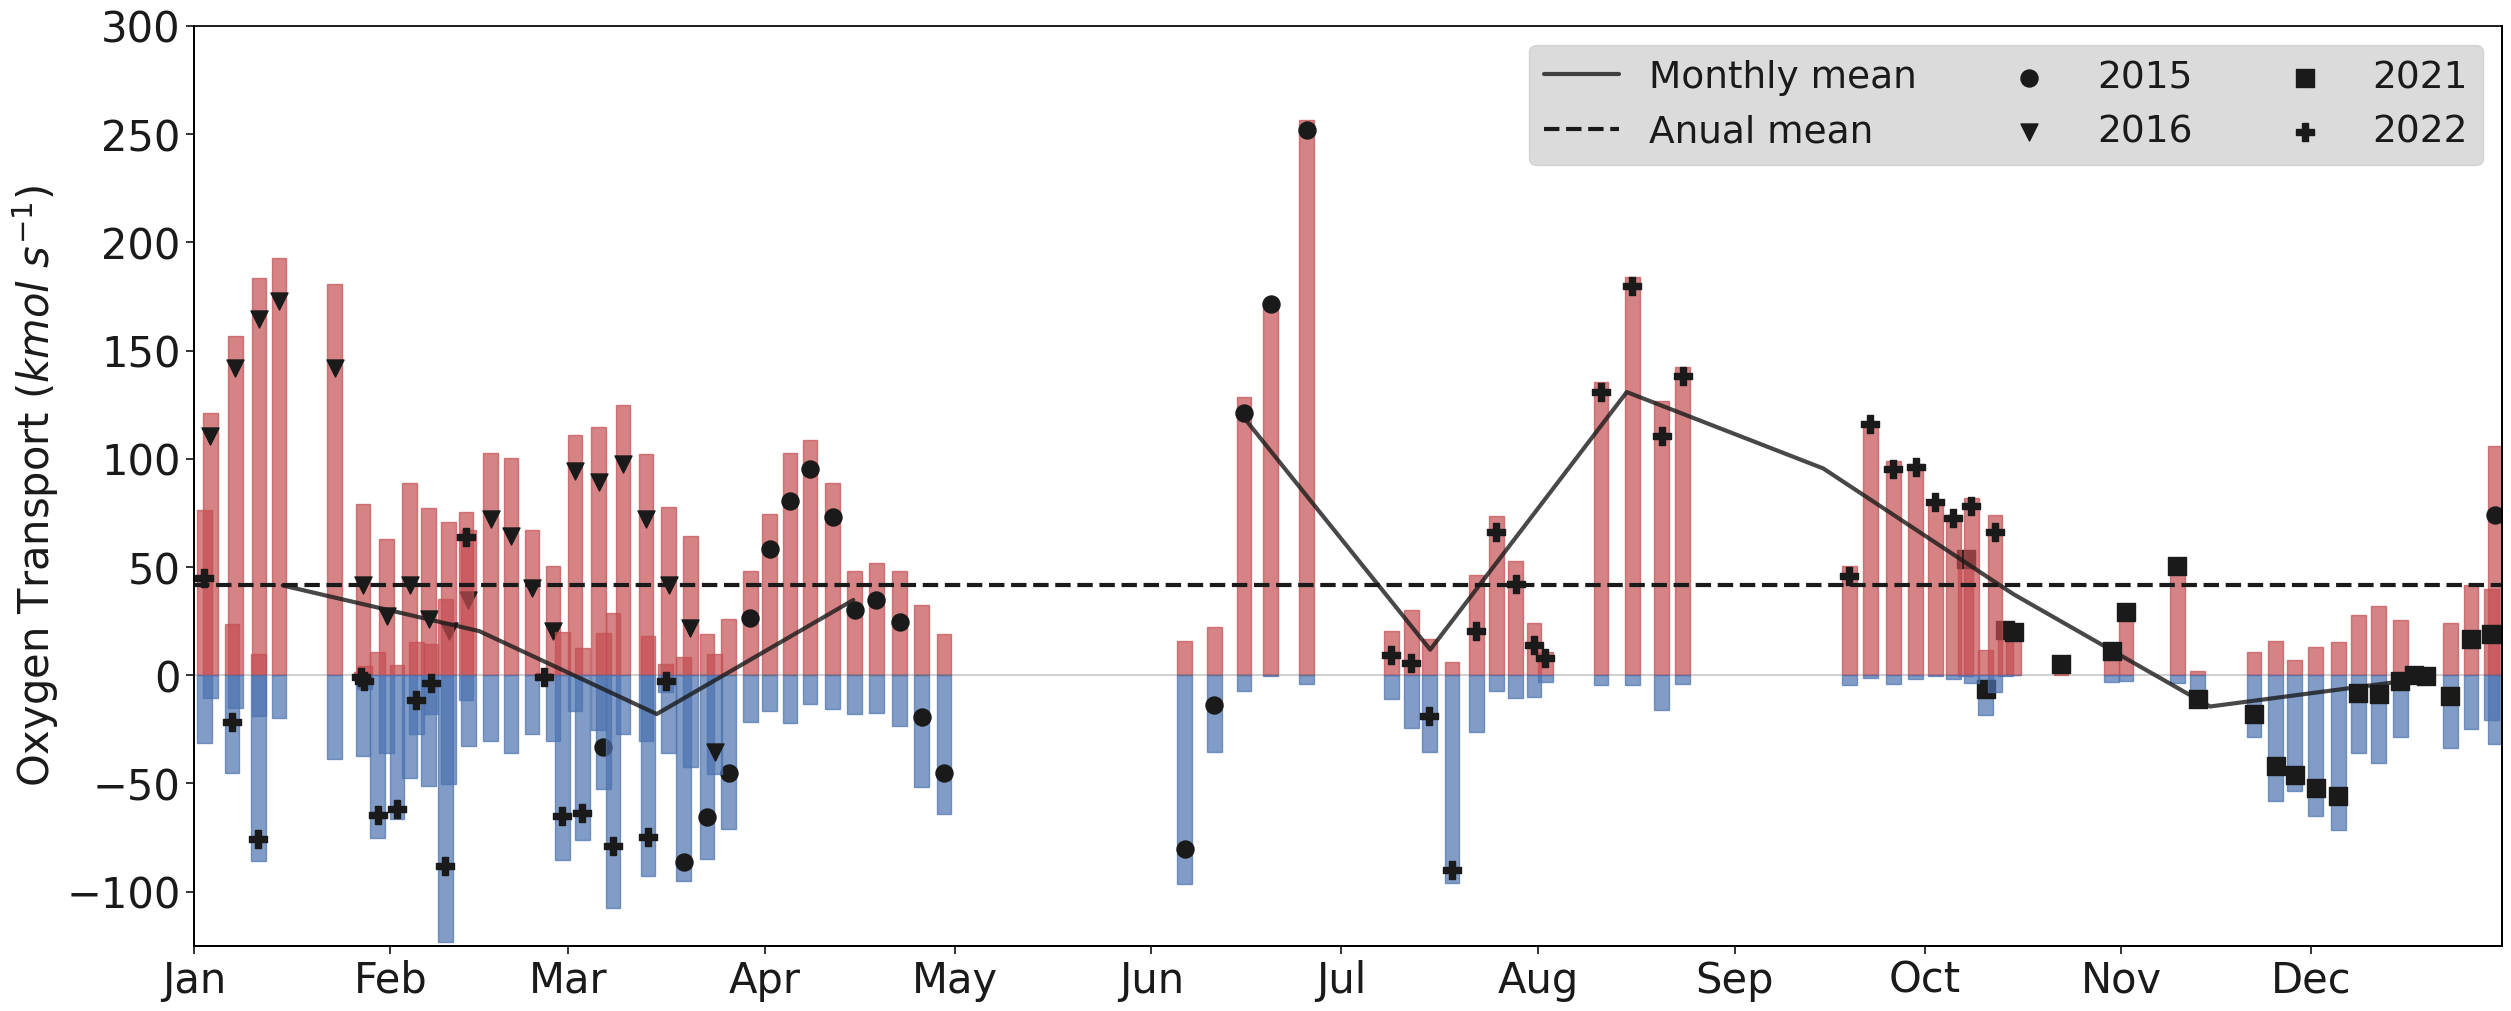

In [55]:
fnts=30
marker_gl=["o", 'v', "s", "P"]  ## 2015,16,20,21
colors_yr=["k","k","k",'k']
label_yr=['2015', '2016', '2021', '2022']
size=150
linwi=3
'-------------------------'

f=plt.figure(constrained_layout=True, figsize=(25,10))
NNrow=30
spec2 = GridSpec(ncols=1, nrows=NNrow, figure=f)

'-------------------------'
'-------------------------'

ax = f.add_subplot(spec2[:, :])

ax.axhline(0, c='dimgrey', alpha=0.3)

ax.bar(ds_02.time, o2_tansp_posneg(ds_02)[0],  width=199999999999999, color='r', edgecolor='r', alpha=0.7)
ax.bar(ds_02.time, o2_tansp_posneg(ds_02)[1],  width=199999999999999, color='b', edgecolor='b', alpha=0.7)
ax.bar(ds_79.time, o2_tansp_posneg(ds_79)[0],  width=199999999999999, color='r', edgecolor='r', alpha=0.7)
ax.bar(ds_79.time, o2_tansp_posneg(ds_79)[1],  width=199999999999999, color='b', edgecolor='b', alpha=0.7)
ax.bar(ds_10.time, o2_tansp_posneg(ds_10)[0],  width=199999999999999, color='r', edgecolor='r', alpha=0.7)
ax.bar(ds_10.time, o2_tansp_posneg(ds_10)[1],  width=199999999999999, color='b', edgecolor='b', alpha=0.7)

ax.scatter(ds_02.time, o2_tansp(ds_02), marker=marker_gl[0], c='k', s=size, label='2015')
ax.scatter(ds_79.time, o2_tansp(ds_79), marker=marker_gl[0], c='k', s=size)
ax.scatter(ds_10.time, o2_tansp(ds_10), marker=marker_gl[0], c='k', s=size)

# ax.set_ylim(-0.4*10**2,0.6*10**2)
ax.set_ylim(-125,300)


ax.set_xlim(pd.Timestamp('01-01-2015'), pd.Timestamp('12-31-2015'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_ylabel('Oxygen Transport $(kmol$ $s^{-1})$', fontsize=fnts)
plt.tick_params(axis='both', which='major', labelsize=fnts)

'------'

ax=ax.twiny()

ax.bar(ds_10.time, o2_tansp_posneg(ds_10)[0],  width=199999999999999, color='r', edgecolor='r', alpha=0.7)
ax.bar(ds_10.time, o2_tansp_posneg(ds_10)[1],  width=199999999999999, color='b', edgecolor='b', alpha=0.7)

ax.scatter(ds_10.time, o2_tansp(ds_10), marker=marker_gl[1], c='k', s=size, label='2016')
ax.set_xlim(pd.Timestamp('01-01-2016'), pd.Timestamp('12-31-2016'))
plt.gca().set_xticks([])
# ax.set_ylim(-0.4*10**2,0.6*10**2)
ax.set_ylim(-125,300)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=fnts)

'------'

ax=ax.twiny()

ax.bar(ds_22.time, o2_tansp22_posneg(ds_22)[0],  width=199999999999999, color='r', edgecolor='r', alpha=0.7)
ax.bar(ds_22.time, o2_tansp22_posneg(ds_22)[1],  width=199999999999999, color='b', edgecolor='b', alpha=0.7)

ax.scatter(ds_22.time, o2_tansp22(ds_22), marker=marker_gl[2], c='k', s=size, label='2021')

ax.set_xlim(pd.Timestamp('01-01-2021'), pd.Timestamp('12-31-2021'))
plt.gca().set_xticks([])
# ax.set_ylim(-0.4*10**2,0.6*10**2)
ax.set_ylim(-125,300)
ax.spines['top'].set_visible(False)
plt.tick_params(axis='both', which='major', labelsize=fnts)

'------'

ax=ax.twiny()
ax.bar(ds_22.time, o2_tansp22_posneg(ds_22)[0],  width=199999999999999, color='r', edgecolor='r', alpha=0.7)
ax.bar(ds_22.time, o2_tansp22_posneg(ds_22)[1],  width=199999999999999, color='b', edgecolor='b', alpha=0.7)

ax.plot(month_axis, transport_permonth, c='k',alpha=0.8, linewidth=linwi, label='Monthly mean')
ax.axhline(np.nanmean(transport_permonth.values), c='k', alpha=1 , lw=linwi, ls='dashed', label='Anual mean')
ax.scatter(0,0,marker=marker_gl[0], c='k', s=size, label='2015')
ax.scatter(0,0,marker=marker_gl[1], c='k', s=size, label='2016')
ax.scatter(0,0,marker=marker_gl[2], c='k', s=size, label='2021')
ax.scatter(ds_22.time, o2_tansp22(ds_22),marker=marker_gl[3], c='k', s=size, label='2022')
ax.set_xlim(pd.Timestamp('01-01-2022'), pd.Timestamp('12-31-2022'))
plt.gca().set_xticks([])


# ax.set_ylim(-0.4*10**2,0.6*10**2)
ax.set_ylim(-125,300)
ax.spines['top'].set_visible(False)
# ax.set_yticks([-0.3*10**2, 0*10**2, 0.3*10**2, 0.6*10**2])

plt.tick_params(axis='both', which='major', labelsize=fnts)


plt.legend(ncol=3, loc=1, fontsize=fnts-3, fancybox=True ,facecolor='lightgrey')
plt.savefig('Figure_6.png', dpi=600)

# Some stats on transport!

In [ ]:
ratio_5=pd.DataFrame((transp/transp_all)).rolling(5, center=True).median()
ratio_1=pd.DataFrame((transp/transp_all))
len((ratio_5<0)), len(taxis[(ratio_1<0)[0]])/np.count_nonzero(~np.isnan(transp_all))

In [1]:
## o2 transp

In [79]:
# Total o2 transport per year:
per_yr=np.nanmean(transport_permonth.values)*(3.156*(10**7))*1e-9
print(per_yr, per_yr/24*100)  ## Tmol a yr  ,  % of o2 of the omz (OMZ o2 content is 25Tmol)

1.3143288872318528 5.476370363466054


In [80]:
print(per_yr, per_yr/3.7*100)  ## Tmol a yr  ,  % of o2 of the omz (OMZ o2 content is 25Tmol)

1.3143288872318528 35.52240235761764


In [70]:
per_yr_std=np.nanstd(transport_permonth.values)*(3.156*10**7)*1e-9
print(per_yr_std, per_yr_std/25*100)  ## Tmol a yr  ,  % of o2 of the omz (OMZ o2 content is 25Tmol)

1.571463618520747 6.285854474082988


In [172]:
## how many transects per season?

In [103]:
len(transp_all)/50, len(winter_transp)/50 ,  len(summer_transp[0])/50, 

(47.4, 0.02, 0.56)

In [60]:
# len(transp_all)/50, len(winter_transp)/50 ,  len(summer_transp[0])/50, 

In [ ]:
## interannual variab: mch
mean_tran_mcb2015=ds79.to_xarray().groupby('index.month').mean().sel(month=3)[0].item()
std_tran_mcb2015=ds79.to_xarray().groupby('index.month').std().sel(month=3)[0].item()

mean_tran_mcb2016=ds10.to_xarray().groupby('index.month').mean().sel(month=3)[0].item()
std_tran_mcb2016=ds10.to_xarray().groupby('index.month').std().sel(month=3)[0].item()

mean_tran_mcb2021=ds22.to_xarray().groupby('index.month').mean().sel(month=3)[0].item()
std_tran_mcb2021=ds22.to_xarray().groupby('index.month').std().sel(month=3)[0].item()


## estimates for march

print([mean_tran_mcb2016, mean_tran_mcb2015, mean_tran_mcb2021],np.nanmean([mean_tran_mcb2016, mean_tran_mcb2015, mean_tran_mcb2021])*(2.628*(10**6))/10**9, np.nanstd([mean_tran_mcb2016, mean_tran_mcb2015, mean_tran_mcb2021])*(2.628*(10**6))/10**9)
#kmol / s

## in proper units:)
# -14.114322596886787*(2.628*(10**6))/10**9,  48.930795724899085*(2.628*(10**6))/10**9  ## Tmol month
np.array([54.5099, -40.72,-54.95])*(2.628*(10**6))/10**9, np.array([std_tran_mcb2016, std_tran_mcb2015, std_tran_mcb2021])*(2.628*(10**6))/10**9

## mean tranp per mach 
print(np.nanmean(transport_permonth)*(2.628*(10**6))/10**9)

# TOTAL MEAN TRANSPORT

In [73]:
print(np.nanmean(sum_all_TT), np.nanstd(sum_all_TT)) 

## TOTAL TRANSPORT PER SEASONS
winter_transp=pd.DataFrame(sum_all_TT).set_index(taxis_trans_57[msk_transport]).to_xarray().sel(index=slice('2021-11-01', '2022-02-21'))
summer21_transp=pd.DataFrame(sum_all_TT).set_index(taxis_trans_57[msk_transport]).to_xarray().sel(index=slice('2021-02-21','2021-11-01'))
summer22_transp=pd.DataFrame(sum_all_TT).set_index(taxis_trans_57[msk_transport]).to_xarray().sel(index=slice('2022-02-21','2022-11-01'))
summer_transp=xr.concat([summer21_transp, summer22_transp], dim='index')

print('winter mean', ' + std', '      summer mean', ' + std')
winter_transp[0].mean().values,winter_transp[0].std().values, summer_transp[0].mean().values, summer_transp[0].std().values

0.44982226623071986 2.7956991112665297
winter mean  + std       summer mean  + std


(array(-0.47297748), array(2.58379688), array(1.2253723), array(2.71045779))

# PGW MEAN TRANSPORT

In [74]:
print(np.nanmean(sum_transp), np.nanstd(sum_transp))

## PGW TRANSPORT PGW PER SEASONS
winter_transp=pd.DataFrame(sum_transp).set_index(taxis_trans_57[msk_transport]).to_xarray().sel(index=slice('2021-11-01', '2022-02-21'))
summer21_transp=pd.DataFrame(sum_transp).set_index(taxis_trans_57[msk_transport]).to_xarray().sel(index=slice('2021-02-21','2021-11-01'))
summer22_transp=pd.DataFrame(sum_transp).set_index(taxis_trans_57[msk_transport]).to_xarray().sel(index=slice('2022-02-21','2022-11-01'))
summer_transp=xr.concat([summer21_transp, summer22_transp], dim='index')

print('winter mean', ' + std', '      summer mean', ' + std')
winter_transp[0].mean().values,winter_transp[0].std().values, summer_transp[0].mean().values, summer_transp[0].std().values

0.1586894589548355 0.38606309804360217
winter mean  + std       summer mean  + std


(array(-0.01990532), array(0.26257077), array(0.29825917), array(0.40159856))

In [76]:
# contrib of ogw to total transp and OPOSIN
ratio_=np.nanmean(sum_transp)*100/np.nanmean(sum_all_TT)
print(np.nanmean(ratio_), np.nanstd(ratio_))
ratio_=sum_transp*100/sum_all_TT
oposing=len(ratio_[ratio_<0])*100/np.count_nonzero(~np.isnan(ratio_))  #10%
print(oposing)

35.27825785161145 0.0
6.25


# Ratio between pfw and  transport


In [77]:
ratio_=transp*100/transp_all

# pgw E floow:
ewlow=len(transp[transp>0])*100/np.count_nonzero(~np.isnan(transp))
print('pgw Eflow', ewlow, '   pgw wflow', 100-ewlow)
# total E floow:
ewlow=len(transp_all[transp_all>0])*100/np.count_nonzero(~np.isnan(transp_all))
print('total Eflow', ewlow, '   total wflow', 100-ewlow)
# PGW oposing total transport: 
oposing=len(ratio_[ratio_<0])*100/np.count_nonzero(~np.isnan(ratio_))  #10%
print('oposing flows:', oposing)
# ratio mean
print('mean, median, std of ratio')
print(np.nanmean(np.abs(ratio_)), np.nanmedian(np.abs(ratio_)), np.nanstd(np.abs(ratio_)))

ratio_pgw_totalwater=np.nansum(PGWfr, axis=0)/np.count_nonzero(~np.isnan(PGWfr), axis=0)
print('mean, median, std of ratio')
print(np.nanmean(np.abs(ratio_)), np.nanmedian(np.abs(ratio_)), np.nanstd(np.abs(ratio_)))

pgw Eflow 65.06137865911236    pgw wflow 34.938621340887636
total Eflow 64.05228758169935    total wflow 35.947712418300654
oposing flows: 10.859301227573182
mean, median, std of ratio
73.58244166357657 13.160040564881372 1344.7568041330803
mean, median, std of ratio
73.58244166357657 13.160040564881372 1344.7568041330803


In [78]:
## averaged transect transp:

ratio_=mean_transp[msk_transport]/mean_all_TT[msk_transport]

# pgw E floow:
ewlow=len(mean_transp[msk_transport][mean_transp[msk_transport]>0])*100/np.count_nonzero(~np.isnan(mean_transp[msk_transport]))
print('pgw Eflow', ewlow, '   pgw wflow', 100-ewlow)
# total E floow:
ewlow=len(mean_all_TT[msk_transport][mean_all_TT[msk_transport]>0])*100/np.count_nonzero(~np.isnan(mean_all_TT[msk_transport]))
print('total Eflow', ewlow, '   total wflow', 100-ewlow)
# - oposing: 
oposing=len(ratio_[ratio_<0])*100/np.count_nonzero(~np.isnan(ratio_))  #10%
print('oposing flows:', oposing)
# ratio mean
print('mean, median, std of ratio')
print(np.nanmean(np.abs(ratio_)), np.nanmedian(np.abs(ratio_)), np.nanstd(np.abs(ratio_)))

pgw Eflow 58.333333333333336    pgw wflow 41.666666666666664
total Eflow 60.416666666666664    total wflow 39.583333333333336
oposing flows: 6.25
mean, median, std of ratio
0.20771277846324324 0.13872054576070503 0.3260382353003636


In [59]:
np.sum(mean_all_TT[msk_transport]), np.sum(mean_all_TT[msk_transport][mean_all_TT[msk_transport]>0]), np.sum(mean_all_TT[msk_transport][mean_all_TT[msk_transport]<0])

(<xarray.DataArray 0 ()>
 array(1.25537363),
 <xarray.DataArray 0 ()>
 array(3.38751832),
 <xarray.DataArray 0 ()>
 array(-2.13214469))

In [66]:
np.sum(mean_all_TT[msk_transport]), np.sum(mean_all_TT[msk_transport][mean_all_TT[msk_transport]>0]), np.sum(mean_all_TT[msk_transport][mean_all_TT[msk_transport]<0])

(<xarray.DataArray 0 ()>
 array(1.03142328),
 <xarray.DataArray 0 ()>
 array(3.39828749),
 <xarray.DataArray 0 ()>
 array(-2.36686421))

In [60]:
np.sum(mean_transp[msk_transport]), np.sum(mean_transp[msk_transport][mean_transp[msk_transport]>0]), np.sum(mean_transp[msk_transport][mean_transp[msk_transport]<0])

(<xarray.DataArray 0 ()>
 array(0.41503139),
 <xarray.DataArray 0 ()>
 array(0.60770805),
 <xarray.DataArray 0 ()>
 array(-0.19267666))

In [67]:
np.sum(mean_transp[msk_transport]), np.sum(mean_transp[msk_transport][mean_transp[msk_transport]>0]), np.sum(mean_transp[msk_transport][mean_transp[msk_transport]<0])

(<xarray.DataArray 0 ()>
 array(0.39580068),
 <xarray.DataArray 0 ()>
 array(0.60287993),
 <xarray.DataArray 0 ()>
 array(-0.20707925))